In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import cv2
import os
import nibabel as nib
import matplotlib.pyplot as plt
import shutil
from scipy import ndimage, misc
import sklearn
from sklearn import model_selection as sk_model_selection

In [2]:
print(f'GPU Available:{torch.cuda.is_available()}')
print(f'GPU ID:{torch.cuda.current_device()}')
print(f'GPU Name:{torch.cuda.get_device_name(torch.cuda.current_device())}')

GPU Available:True
GPU ID:0
GPU Name:NVIDIA GeForce RTX 3090


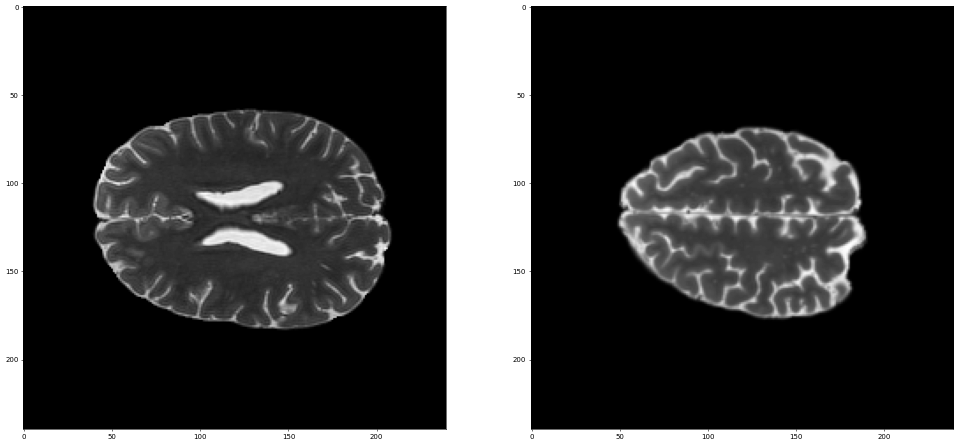

In [29]:
seg_data_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/T4E_MICCAI_BrainTumor-master/data/task1_data'
rescaled_data_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_Prep_Segmentation'
label_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/T4E_MICCAI_BrainTumor-master/data/raw_dicom_data/train_labels.csv'
patient_id = '00753'
img = nib.load(f'{seg_data_path}/BraTS2021_{patient_id}/BraTS2021_{patient_id}_t2.nii.gz')
seg_data = img.get_fdata().astype('float')

rescaled_data = nib.load(f'{rescaled_data_path }/BraTS2021_{patient_id}/BraTS2021_{patient_id}_t2.nii.gz').get_fdata().astype('float')


plt.rcParams['figure.dpi'] = 50

fig, axes = plt.subplots(1,2, figsize=(24, 12))
axes[0].imshow(seg_data[:,:,77],cmap='gray')
axes[1].imshow(rescaled_data[:,:,91] ,cmap='gray')

In [30]:
seg_mask_data_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/Data_Masks_Train'
img = nib.load(f'{seg_mask_data_path}/BraTS2021_{patient_id}.nii.gz')
seg_data_mask = img.get_fdata().astype('float')

seg_data_mask [(seg_data_mask  == 2) | (seg_data_mask  == 4)] = 1

# Caculate real tumor region
region_data = rescaled_data*seg_data_mask 

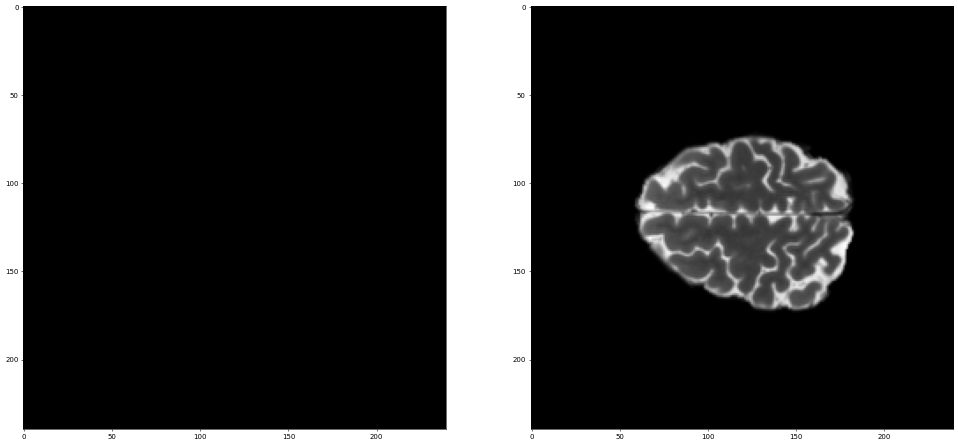

In [31]:
fig, axes = plt.subplots(1,2, figsize=(24, 12))
index = 95
axes[0].imshow(region_data[:,:,index],cmap='gray')
axes[1].imshow(rescaled_data[:,:,index] ,cmap='gray')

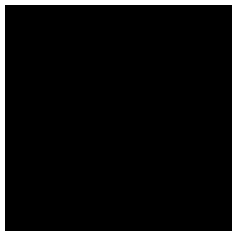

In [34]:
r_data = rescaled_data

from matplotlib import animation, rc
rc('animation', html='jshtml')


def create_animation(ims):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    im = plt.imshow(ims[:,:,50], cmap="gray")

    def animate_func(i):
        im.set_array(ims[:,:,i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = ims.shape[2], interval = 1000//24)

create_animation(r_data)

### Old Code

In [11]:
# path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/T4E_MICCAI_BrainTumor-master/data/task1_data/BraTS2021_00000/BraTS2021_00000_seg.nii.gz'
# img = nib.load(path)
# data = img.get_fdata().astype('float')
# np.unique(data)

In [4]:
seg_full_ids = os.listdir(seg_data_path)[1:]
seg_ids = []
for item in seg_full_ids:
    seg_ids.append(item[-5:])
len(seg_ids)

1251

In [5]:
train_df = pd.read_csv(label_path)
index_name = train_df[(train_df['BraTS21ID'] == 109) | (train_df['BraTS21ID'] == 123) | (train_df['BraTS21ID'] == 709)].index
train_df = train_df.drop(index_name).reset_index(drop=True)
train_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [6]:
clas_raw_ids = train_df['BraTS21ID'].values.astype(str)
clas_ids = []
for item in clas_raw_ids:
    clas_ids.append(item.zfill(5))

In [20]:
non_overlap_ids = [patient for patient in seg_ids if patient not in clas_ids]
print(f'Non overlapping patient counts: {len(non_overlap_ids)}')

Non overlapping patient counts: 677


In [31]:
train_ids, valid_ids = sk_model_selection.train_test_split(non_overlap_ids, test_size=0.2, random_state=42)
print(f'Training set: {len(train_ids)}')
print(f'Valid set: {len(test_ids)}')

Training set: 541
Valid set: 136


In [34]:
train_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/BraTs_2021_Seg_Data/Training'
valid_path = '/mnt/24CC5B14CC5ADF9A/Brain_Tumor_Classification/Datasets/BraTs_2021_Seg_Data/Validation'
# shutil.move(f'{seg_data_path}/BraTS2021_{train_ids[0]}',train_path)

In [30]:
for patient in train_ids[1:]:
    shutil.move(f'{seg_data_path}/BraTS2021_{patient}',train_path)

In [35]:
for patient in valid_ids:
    shutil.move(f'{seg_data_path}/BraTS2021_{patient}',valid_path )